In [1]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

In [2]:
filename='preprocessed_data.pkl'

In [3]:
data=pickle.load(open(filename,'rb')) ###open preprocessed data

In [4]:
len(data)

8450

In [5]:
Y= data.iloc[:,1].values
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [6]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [7]:
X = data['Transcript'].tolist()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0) ##split the data in training and testing

In [10]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

6760
1690
6760
1690


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [13]:
train_tokenizer = create_tokens(X_train)

In [14]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X

In [15]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [16]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6760, 100)
(1690, 100)
(6760,)
(1690,)


In [17]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

8741

In [18]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D, LSTM, Bidirectional
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [20]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(20)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [21]:
cnn_lstm_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 64, verbose = 1, validation_split = 0.1)

Epoch 1/25
96/96 [==============================] - 7s 68ms/step - loss: 0.2546 - accuracy: 0.9366 - val_loss: 0.1760 - val_accuracy: 0.9393
Epoch 2/25
96/96 [==============================] - 5s 56ms/step - loss: 0.1191 - accuracy: 0.9550 - val_loss: 0.1141 - val_accuracy: 0.9645
Epoch 3/25
96/96 [==============================] - 5s 57ms/step - loss: 0.0578 - accuracy: 0.9809 - val_loss: 0.1200 - val_accuracy: 0.9645
Epoch 4/25
96/96 [==============================] - 5s 51ms/step - loss: 0.0334 - accuracy: 0.9908 - val_loss: 0.1303 - val_accuracy: 0.9645
Epoch 5/25
96/96 [==============================] - 5s 56ms/step - loss: 0.0195 - accuracy: 0.9947 - val_loss: 0.1456 - val_accuracy: 0.9645
Epoch 6/25
96/96 [==============================] - 5s 57ms/step - loss: 0.0132 - accuracy: 0.9964 - val_loss: 0.1570 - val_accuracy: 0.9571
Epoch 7/25
96/96 [==============================] - 5s 52ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.1687 - val_accuracy: 0.9571
Epoch 8/25
96

In [22]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 0s 9ms/step - loss: 0.2182 - accuracy: 0.9586


0.9585798978805542

In [23]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_lstm_history.history['loss'])
plt.plot(cnn_lstm_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

<Figure size 640x480 with 1 Axes>

In [24]:
model.save('cnn_lstm_model.hdf5')   ###save the model

In [25]:
model.load_weights('cnn_lstm_model.hdf5')

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [27]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [28]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[1556   34]
 [  36   64]]
precision is 0.6530612244897959
recall is  0.64
F1 score 0.6464646464646464
specificity is 0.9786163522012579


Instructions for updating:
Please use `model.predict()` instead.


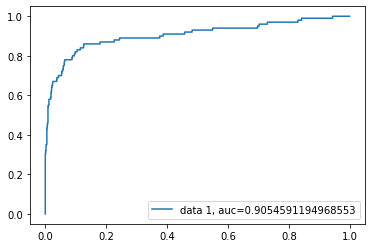

In [29]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [30]:
embeddings = dict()                                 ##read glove vector file
f = open('C:/Users/HP/Desktop/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()

In [31]:
embedding_matrix = np.zeros((vocab_len, 100))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:

model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable= False)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
cnn_lstm_pretrained_history=model.fit(X_train, Y_train, epochs = 15, batch_size = 64, verbose = 1, validation_split = 0.1)

Epoch 1/15
96/96 [==============================] - 9s 95ms/step - loss: 0.1893 - accuracy: 0.9306 - val_loss: 0.1304 - val_accuracy: 0.9497
Epoch 2/15
96/96 [==============================] - 7s 76ms/step - loss: 0.1087 - accuracy: 0.9620 - val_loss: 0.1134 - val_accuracy: 0.9601
Epoch 3/15
96/96 [==============================] - 8s 84ms/step - loss: 0.0875 - accuracy: 0.9698 - val_loss: 0.1154 - val_accuracy: 0.9601
Epoch 4/15
96/96 [==============================] - 7s 71ms/step - loss: 0.0551 - accuracy: 0.9788 - val_loss: 0.1078 - val_accuracy: 0.9645
Epoch 5/15
96/96 [==============================] - 7s 78ms/step - loss: 0.0399 - accuracy: 0.9857 - val_loss: 0.1183 - val_accuracy: 0.9675
Epoch 6/15
96/96 [==============================] - 7s 68ms/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 0.1418 - val_accuracy: 0.9689
Epoch 7/15
96/96 [==============================] - 7s 78ms/step - loss: 0.0154 - accuracy: 0.9949 - val_loss: 0.1603 - val_accuracy: 0.9719
Epoch 8/15
96

In [34]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 1s 18ms/step - loss: 0.2235 - accuracy: 0.9651


0.9650887846946716

In [35]:
def model_cnn_lstm_create(optimizer = 'Adam',
                 dropout_rate = 0.2, nb_filters = 256, kernel_size = 5,pool_size=4,units = 128):
    
    model = Sequential()
    e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable= False)
    model.add(e)
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = pool_size))
    model.add(Bidirectional(LSTM(units)))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [36]:
param_grid = {
    'units': [10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] units=10 ........................................................
Epoch 1/10
141/141 - 5s - loss: 0.1862 - accuracy: 0.9432
Epoch 2/10
141/141 - 6s - loss: 0.1105 - accuracy: 0.9643
Epoch 3/10
141/141 - 6s - loss: 0.0753 - accuracy: 0.9780
Epoch 4/10
141/141 - 5s - loss: 0.0550 - accuracy: 0.9836
Epoch 5/10
141/141 - 5s - loss: 0.0379 - accuracy: 0.9882
Epoch 6/10
141/141 - 6s - loss: 0.0253 - accuracy: 0.9936
Epoch 7/10
141/141 - 5s - loss: 0.0172 - accuracy: 0.9958
Epoch 8/10
141/141 - 6s - loss: 0.0185 - accuracy: 0.9945
Epoch 9/10
141/141 - 6s - loss: 0.0161 - accuracy: 0.9949
Epoch 10/10
141/141 - 5s - loss: 0.0112 - accuracy: 0.9973
71/71 - 1s - loss: 0.1695 - accuracy: 0.9618
[CV] ......................................... units=10, total= 1.0min
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/10
141/141 - 5s - loss: 0.2258 - accuracy: 0.9288
Epoch 2/10
141/141 - 5s - loss: 0.1262 - accuracy: 0.9590
Epoch 3/10
141/141 - 6s - loss: 0.1019 - accuracy: 0.9692
Epoch 4/10
141/141 - 5s - loss: 0.0732 - accuracy: 0.9758
Epoch 5/10
141/141 - 5s - loss: 0.0504 - accuracy: 0.9825
Epoch 6/10
141/141 - 6s - loss: 0.0422 - accuracy: 0.9874
Epoch 7/10
141/141 - 5s - loss: 0.0298 - accuracy: 0.9907
Epoch 8/10
141/141 - 6s - loss: 0.0275 - accuracy: 0.9907
Epoch 9/10
141/141 - 6s - loss: 0.0233 - accuracy: 0.9922
Epoch 10/10
141/141 - 5s - loss: 0.0106 - accuracy: 0.9973
71/71 - 1s - loss: 0.1313 - accuracy: 0.9663
[CV] ......................................... units=10, total= 1.1min
[CV] units=10 ........................................................
Epoch 1/10
141/141 - 6s - loss: 0.1902 - accuracy: 0.9414
Epoch 2/10
141/141 - 5s - loss: 0.1144 - accuracy: 0.9616
Epoch 3/10
141/141 - 6s - loss: 0.0814 - accuracy: 0.9740
Epoch 4/10
141/141 - 6s - loss: 0.0521 - accuracy: 0.9842


Epoch 10/10
141/141 - 11s - loss: 0.0065 - accuracy: 0.9976
71/71 - 3s - loss: 0.1372 - accuracy: 0.9623
[CV] ........................................ units=128, total= 2.1min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 17.2min finished


Epoch 1/10
212/212 - 10s - loss: 0.1774 - accuracy: 0.9393
Epoch 2/10
212/212 - 9s - loss: 0.1026 - accuracy: 0.9663
Epoch 3/10
212/212 - 9s - loss: 0.0785 - accuracy: 0.9746
Epoch 4/10
212/212 - 10s - loss: 0.0559 - accuracy: 0.9827
Epoch 5/10
212/212 - 9s - loss: 0.0361 - accuracy: 0.9877
Epoch 6/10
212/212 - 10s - loss: 0.0250 - accuracy: 0.9916
Epoch 7/10
212/212 - 9s - loss: 0.0145 - accuracy: 0.9947
Epoch 8/10
212/212 - 9s - loss: 0.0121 - accuracy: 0.9957
Epoch 9/10
212/212 - 9s - loss: 0.0124 - accuracy: 0.9953
Epoch 10/10
212/212 - 9s - loss: 0.0156 - accuracy: 0.9935
Best accuracy:  0.9686390648138594
Best parameters:  {'units': 20}


In [37]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] optimizer=RMSprop ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 13s - loss: 0.1455 - accuracy: 0.9454
Epoch 2/10
141/141 - 13s - loss: 0.0866 - accuracy: 0.9716
Epoch 3/10
141/141 - 13s - loss: 0.0536 - accuracy: 0.9831
Epoch 4/10
141/141 - 13s - loss: 0.0349 - accuracy: 0.9880
Epoch 5/10
141/141 - 14s - loss: 0.0194 - accuracy: 0.9936
Epoch 6/10
141/141 - 13s - loss: 0.0123 - accuracy: 0.9960
Epoch 7/10
141/141 - 13s - loss: 0.0155 - accuracy: 0.9960
Epoch 8/10
141/141 - 13s - loss: 0.0121 - accuracy: 0.9964
Epoch 9/10
141/141 - 13s - loss: 0.0086 - accuracy: 0.9973
Epoch 10/10
141/141 - 13s - loss: 0.0116 - accuracy: 0.9971
71/71 - 3s - loss: 0.2391 - accuracy: 0.9645
[CV] ................................ optimizer=RMSprop, total= 2.4min
[CV] optimizer=RMSprop ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


Epoch 1/10
141/141 - 14s - loss: 0.1513 - accuracy: 0.9439
Epoch 2/10
141/141 - 14s - loss: 0.0908 - accuracy: 0.9683
Epoch 3/10
141/141 - 14s - loss: 0.0490 - accuracy: 0.9814
Epoch 4/10
141/141 - 14s - loss: 0.0298 - accuracy: 0.9909
Epoch 5/10
141/141 - 14s - loss: 0.0153 - accuracy: 0.9949
Epoch 6/10
141/141 - 14s - loss: 0.0107 - accuracy: 0.9971
Epoch 7/10
141/141 - 15s - loss: 0.0112 - accuracy: 0.9964
Epoch 8/10
141/141 - 14s - loss: 0.0085 - accuracy: 0.9969
Epoch 9/10
141/141 - 14s - loss: 0.0077 - accuracy: 0.9978
Epoch 10/10
141/141 - 14s - loss: 0.0082 - accuracy: 0.9969
71/71 - 4s - loss: 0.1957 - accuracy: 0.9654
[CV] ................................ optimizer=RMSprop, total= 2.6min
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
141/141 - 14s - loss: 0.1576 - accuracy: 0.9474
Epoch 2/10
141/141 - 14s - loss: 0.0970 - accuracy: 0.9669
Epoch 3/10
141/141 - 14s - loss: 0.0575 - accuracy: 0.9796
Epoch 4/10
141/141 - 15s - loss: 0.0242 - acc

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 22.8min finished


Epoch 1/10
212/212 - 23s - loss: 0.1389 - accuracy: 0.9534
Epoch 2/10
212/212 - 22s - loss: 0.0834 - accuracy: 0.9709
Epoch 3/10
212/212 - 23s - loss: 0.0510 - accuracy: 0.9834
Epoch 4/10
212/212 - 22s - loss: 0.0253 - accuracy: 0.9913
Epoch 5/10
212/212 - 22s - loss: 0.0147 - accuracy: 0.9945
Epoch 6/10
212/212 - 23s - loss: 0.0105 - accuracy: 0.9963
Epoch 7/10
212/212 - 22s - loss: 0.0098 - accuracy: 0.9969
Epoch 8/10
212/212 - 23s - loss: 0.0084 - accuracy: 0.9970
Epoch 9/10
212/212 - 22s - loss: 0.0081 - accuracy: 0.9972
Epoch 10/10
212/212 - 23s - loss: 0.0127 - accuracy: 0.9945
Best accuracy:  0.9677514782495047
Best parameters:  {'optimizer': 'Adam'}


In [38]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] kernel_size=3, nb_filters=128 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 11s - loss: 0.1703 - accuracy: 0.9425
Epoch 2/10
141/141 - 9s - loss: 0.0979 - accuracy: 0.9640
Epoch 3/10
141/141 - 10s - loss: 0.0651 - accuracy: 0.9785
Epoch 4/10
141/141 - 10s - loss: 0.0363 - accuracy: 0.9889
Epoch 5/10
141/141 - 9s - loss: 0.0266 - accuracy: 0.9916
Epoch 6/10
141/141 - 11s - loss: 0.0174 - accuracy: 0.9951
Epoch 7/10
141/141 - 9s - loss: 0.0107 - accuracy: 0.9969
Epoch 8/10
141/141 - 9s - loss: 0.0099 - accuracy: 0.9973
Epoch 9/10
141/141 - 11s - loss: 0.0069 - accuracy: 0.9976
Epoch 10/10
141/141 - 9s - loss: 0.0067 - accuracy: 0.9978
71/71 - 3s - loss: 0.2292 - accuracy: 0.9632
[CV] .................... kernel_size=3, nb_filters=128, total= 1.8min
[CV] kernel_size=3, nb_filters=128 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


Epoch 1/10
141/141 - 10s - loss: 0.1762 - accuracy: 0.9363
Epoch 2/10
141/141 - 9s - loss: 0.1046 - accuracy: 0.9609
Epoch 3/10
141/141 - 10s - loss: 0.0665 - accuracy: 0.9740
Epoch 4/10
141/141 - 9s - loss: 0.0411 - accuracy: 0.9845
Epoch 5/10
141/141 - 9s - loss: 0.0218 - accuracy: 0.9933
Epoch 6/10
141/141 - 10s - loss: 0.0142 - accuracy: 0.9960
Epoch 7/10
141/141 - 9s - loss: 0.0093 - accuracy: 0.9971
Epoch 8/10
141/141 - 10s - loss: 0.0066 - accuracy: 0.9978
Epoch 9/10
141/141 - 9s - loss: 0.0109 - accuracy: 0.9947
Epoch 10/10
141/141 - 9s - loss: 0.0100 - accuracy: 0.9958
71/71 - 2s - loss: 0.1875 - accuracy: 0.9654
[CV] .................... kernel_size=3, nb_filters=128, total= 1.8min
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10
141/141 - 9s - loss: 0.1764 - accuracy: 0.9401
Epoch 2/10
141/141 - 10s - loss: 0.1069 - accuracy: 0.9643
Epoch 3/10
141/141 - 10s - loss: 0.0749 - accuracy: 0.9754
Epoch 4/10
141/141 - 9s - loss: 0.0530 - accuracy: 0

Epoch 10/10
141/141 - 9s - loss: 0.0096 - accuracy: 0.9969
71/71 - 2s - loss: 0.1242 - accuracy: 0.9640
[CV] .................... kernel_size=5, nb_filters=256, total= 1.7min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 19.8min finished


Epoch 1/10
212/212 - 10s - loss: 0.1519 - accuracy: 0.9451
Epoch 2/10
212/212 - 10s - loss: 0.0887 - accuracy: 0.9698
Epoch 3/10
212/212 - 10s - loss: 0.0555 - accuracy: 0.9806
Epoch 4/10
212/212 - 10s - loss: 0.0310 - accuracy: 0.9882
Epoch 5/10
212/212 - 10s - loss: 0.0201 - accuracy: 0.9935
Epoch 6/10
212/212 - 10s - loss: 0.0150 - accuracy: 0.9947
Epoch 7/10
212/212 - 10s - loss: 0.0151 - accuracy: 0.9948
Epoch 8/10
212/212 - 12s - loss: 0.0102 - accuracy: 0.9966
Epoch 9/10
212/212 - 11s - loss: 0.0061 - accuracy: 0.9981
Epoch 10/10
212/212 - 11s - loss: 0.0123 - accuracy: 0.9960
Best accuracy:  0.9683431984493013
Best parameters:  {'kernel_size': 5, 'nb_filters': 128}


In [39]:
param_grid = {
    'dropout_rate': [0.1,0.2,0.3,0.4,0.5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 9s - loss: 0.1567 - accuracy: 0.9416
Epoch 2/10
141/141 - 9s - loss: 0.0909 - accuracy: 0.9707
Epoch 3/10
141/141 - 8s - loss: 0.0492 - accuracy: 0.9851
Epoch 4/10
141/141 - 9s - loss: 0.0308 - accuracy: 0.9885
Epoch 5/10
141/141 - 8s - loss: 0.0139 - accuracy: 0.9951
Epoch 6/10
141/141 - 9s - loss: 0.0094 - accuracy: 0.9973
Epoch 7/10
141/141 - 9s - loss: 0.0092 - accuracy: 0.9973
Epoch 8/10
141/141 - 9s - loss: 0.0061 - accuracy: 0.9973
Epoch 9/10
141/141 - 9s - loss: 0.0160 - accuracy: 0.9951
Epoch 10/10
141/141 - 9s - loss: 0.0082 - accuracy: 0.9969
71/71 - 2s - loss: 0.1851 - accuracy: 0.9623
[CV] ................................. dropout_rate=0.1, total= 1.6min
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


Epoch 1/10
141/141 - 9s - loss: 0.1669 - accuracy: 0.9396
Epoch 2/10
141/141 - 9s - loss: 0.1013 - accuracy: 0.9654
Epoch 3/10
141/141 - 9s - loss: 0.0528 - accuracy: 0.9800
Epoch 4/10
141/141 - 9s - loss: 0.0271 - accuracy: 0.9898
Epoch 5/10
141/141 - 9s - loss: 0.0134 - accuracy: 0.9951
Epoch 6/10
141/141 - 9s - loss: 0.0130 - accuracy: 0.9940
Epoch 7/10
141/141 - 9s - loss: 0.0115 - accuracy: 0.9958
Epoch 8/10
141/141 - 9s - loss: 0.0051 - accuracy: 0.9976
Epoch 9/10
141/141 - 9s - loss: 0.0042 - accuracy: 0.9978
Epoch 10/10
141/141 - 9s - loss: 0.0041 - accuracy: 0.9984
71/71 - 2s - loss: 0.1591 - accuracy: 0.9694
[CV] ................................. dropout_rate=0.1, total= 1.6min
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
141/141 - 9s - loss: 0.1745 - accuracy: 0.9379
Epoch 2/10
141/141 - 9s - loss: 0.1045 - accuracy: 0.9665
Epoch 3/10
141/141 - 9s - loss: 0.0709 - accuracy: 0.9749
Epoch 4/10
141/141 - 9s - loss: 0.0337 - accuracy: 0.9898


Epoch 10/10
141/141 - 10s - loss: 0.0038 - accuracy: 0.9989
71/71 - 2s - loss: 0.2899 - accuracy: 0.9618
[CV] ................................. dropout_rate=0.4, total= 1.7min
[CV] dropout_rate=0.5 ................................................
Epoch 1/10
141/141 - 9s - loss: 0.1580 - accuracy: 0.9498
Epoch 2/10
141/141 - 10s - loss: 0.0787 - accuracy: 0.9725
Epoch 3/10
141/141 - 10s - loss: 0.0503 - accuracy: 0.9820
Epoch 4/10
141/141 - 10s - loss: 0.0244 - accuracy: 0.9925
Epoch 5/10
141/141 - 9s - loss: 0.0143 - accuracy: 0.9960
Epoch 6/10
141/141 - 10s - loss: 0.0103 - accuracy: 0.9973
Epoch 7/10
141/141 - 9s - loss: 0.0091 - accuracy: 0.9969
Epoch 8/10
141/141 - 10s - loss: 0.0087 - accuracy: 0.9969
Epoch 9/10
141/141 - 10s - loss: 0.0106 - accuracy: 0.9960
Epoch 10/10
141/141 - 10s - loss: 0.0070 - accuracy: 0.9978
71/71 - 2s - loss: 0.2207 - accuracy: 0.9645
[CV] ................................. dropout_rate=0.5, total= 1.7min
[CV] dropout_rate=0.5 ...........................

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 25.0min finished


Epoch 1/10
212/212 - 14s - loss: 0.1506 - accuracy: 0.9499
Epoch 2/10
212/212 - 15s - loss: 0.0875 - accuracy: 0.9712
Epoch 3/10
212/212 - 15s - loss: 0.0483 - accuracy: 0.9833
Epoch 4/10
212/212 - 15s - loss: 0.0230 - accuracy: 0.9923
Epoch 5/10
212/212 - 15s - loss: 0.0184 - accuracy: 0.9938
Epoch 6/10
212/212 - 15s - loss: 0.0115 - accuracy: 0.9957
Epoch 7/10
212/212 - 15s - loss: 0.0073 - accuracy: 0.9969
Epoch 8/10
212/212 - 15s - loss: 0.0116 - accuracy: 0.9957
Epoch 9/10
212/212 - 14s - loss: 0.0085 - accuracy: 0.9963
Epoch 10/10
212/212 - 15s - loss: 0.0093 - accuracy: 0.9967
Best accuracy:  0.9668638994884209
Best parameters:  {'dropout_rate': 0.5}


In [40]:
param_grid = {
    'batch_size': [32,64,128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 10s - loss: 0.1760 - accuracy: 0.9359
Epoch 2/10
141/141 - 9s - loss: 0.0946 - accuracy: 0.9683
Epoch 3/10
141/141 - 9s - loss: 0.0556 - accuracy: 0.9791
Epoch 4/10
141/141 - 9s - loss: 0.0278 - accuracy: 0.9905
Epoch 5/10
141/141 - 9s - loss: 0.0172 - accuracy: 0.9945
Epoch 6/10
141/141 - 10s - loss: 0.0096 - accuracy: 0.9973
Epoch 7/10
141/141 - 10s - loss: 0.0089 - accuracy: 0.9969
Epoch 8/10
141/141 - 10s - loss: 0.0067 - accuracy: 0.9971
Epoch 9/10
141/141 - 10s - loss: 0.0057 - accuracy: 0.9978
Epoch 10/10
141/141 - 9s - loss: 0.0047 - accuracy: 0.9984
71/71 - 2s - loss: 0.1740 - accuracy: 0.9641
[CV] .................................... batch_size=32, total= 1.7min
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


Epoch 1/10
141/141 - 9s - loss: 0.1583 - accuracy: 0.9472
Epoch 2/10
141/141 - 10s - loss: 0.0943 - accuracy: 0.9667
Epoch 3/10
141/141 - 9s - loss: 0.0485 - accuracy: 0.9834
Epoch 4/10
141/141 - 10s - loss: 0.0235 - accuracy: 0.9922
Epoch 5/10
141/141 - 9s - loss: 0.0119 - accuracy: 0.9962
Epoch 6/10
141/141 - 9s - loss: 0.0104 - accuracy: 0.9973
Epoch 7/10
141/141 - 10s - loss: 0.0056 - accuracy: 0.9982
Epoch 8/10
141/141 - 10s - loss: 0.0053 - accuracy: 0.9978
Epoch 9/10
141/141 - 10s - loss: 0.0041 - accuracy: 0.9978
Epoch 10/10
141/141 - 9s - loss: 0.0047 - accuracy: 0.9973
71/71 - 2s - loss: 0.1739 - accuracy: 0.9672
[CV] .................................... batch_size=32, total= 1.7min
[CV] batch_size=32 ...................................................
Epoch 1/10
141/141 - 9s - loss: 0.1680 - accuracy: 0.9410
Epoch 2/10
141/141 - 9s - loss: 0.0912 - accuracy: 0.9674
Epoch 3/10
141/141 - 9s - loss: 0.0494 - accuracy: 0.9834
Epoch 4/10
141/141 - 9s - loss: 0.0234 - accuracy: 0.

[CV] ................................... batch_size=256, total= 1.9min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 22.5min finished


Epoch 1/10
53/53 - 18s - loss: 0.1991 - accuracy: 0.9291
Epoch 2/10
53/53 - 18s - loss: 0.1206 - accuracy: 0.9567
Epoch 3/10
53/53 - 18s - loss: 0.0796 - accuracy: 0.9723
Epoch 4/10
53/53 - 18s - loss: 0.0499 - accuracy: 0.9831
Epoch 5/10
53/53 - 18s - loss: 0.0320 - accuracy: 0.9891
Epoch 6/10
53/53 - 18s - loss: 0.0214 - accuracy: 0.9929
Epoch 7/10
53/53 - 18s - loss: 0.0115 - accuracy: 0.9967
Epoch 8/10
53/53 - 18s - loss: 0.0117 - accuracy: 0.9953
Epoch 9/10
53/53 - 18s - loss: 0.0110 - accuracy: 0.9966
Epoch 10/10
53/53 - 18s - loss: 0.0058 - accuracy: 0.9982
Best accuracy:  0.9674556065945936
Best parameters:  {'batch_size': 128}


In [41]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable= False)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [42]:
cnn_lstm_pretrained_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
48/48 [==============================] - 5s 101ms/step - loss: 0.2883 - accuracy: 0.9255 - val_loss: 0.2011 - val_accuracy: 0.9393
Epoch 2/25
48/48 [==============================] - 4s 84ms/step - loss: 0.1953 - accuracy: 0.9385 - val_loss: 0.1393 - val_accuracy: 0.9482
Epoch 3/25
48/48 [==============================] - 4s 81ms/step - loss: 0.1363 - accuracy: 0.9548 - val_loss: 0.1159 - val_accuracy: 0.9556
Epoch 4/25
48/48 [==============================] - 4s 83ms/step - loss: 0.1099 - accuracy: 0.9637 - val_loss: 0.1096 - val_accuracy: 0.9645
Epoch 5/25
48/48 [==============================] - 4s 88ms/step - loss: 0.1013 - accuracy: 0.9678 - val_loss: 0.1077 - val_accuracy: 0.9645
Epoch 6/25
48/48 [==============================] - 4s 83ms/step - loss: 0.0793 - accuracy: 0.9749 - val_loss: 0.1098 - val_accuracy: 0.9675
Epoch 7/25
48/48 [==============================] - 4s 84ms/step - loss: 0.0710 - accuracy: 0.9763 - val_loss: 0.1112 - val_accuracy: 0.9675
Epoch 8/25
4

In [43]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 1s 10ms/step - loss: 0.1618 - accuracy: 0.9657


0.9656804800033569

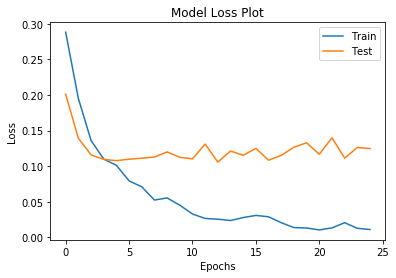

In [43]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_lstm_pretrained_history.history['loss'])
plt.plot(cnn_lstm_pretrained_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [44]:
model.save('cnn_lstm_pretrained_model.hdf5')   ###save the model

In [45]:
model.load_weights('cnn_lstm_pretrained_model.hdf5')

In [46]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [47]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[1553   37]
 [  33   67]]
precision is 0.6442307692307693
recall is  0.67
F1 score 0.6568627450980393
specificity is 0.9767295597484277


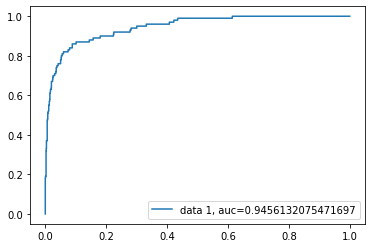

In [48]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()